<a href="https://colab.research.google.com/github/IBM-CSM-SG/DTSA5511/blob/main/Week_5_GANs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
### Check GPU
!nvidia-smi
import tensorflow as tf
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))

Fri Mar  7 12:48:14 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   76C    P0             46W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
        print("GPU is now enabled!")
    except RuntimeError as e:
        print("Error setting GPU:", e)
else:
    print("No GPU available. Using CPU instead.")

GPU is now enabled!


In [3]:
import os
import shutil
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
import random
import time

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, ReLU, LeakyReLU, Add, BatchNormalization
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError

from skimage.metrics import structural_similarity as ssim

In [4]:
print("TensorFlow Version:", tf.__version__)

TensorFlow Version: 2.18.0


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


1. Brief description of the problem and data

**Description:**

In this project, Generative Adversarial Networks (GANs) are used to create Monet-style paintings from real photos. Monet’s unique style, including brush strokes and colors, is learned by the model. A generator is trained to produce paintings, while a discriminator is used to distinguish real from generated images. The goal is to generate 7,000 to 10,000 Monet-style images that appear authentic.The methodology will include the following stages:

* Brief Description of the Problem and Data
* Exploratory Data Analysis (EDA)
* Model Architecture and Development
* Results and Analysis
* Conclusion

Noted: The result will be evaluated on MiFID (Memorization-informed Fréchet Inception Distance)

**Data:**

The original dataset provides images in both JPEG and TFRecord formats. It consists of 300 Monet paintings and 7,028 real-world photos, all sized 256x256 pixels. While TFRecords are available for practice, we will use only the JPEG format for simplicity and ease of processing. The Monet paintings will be used for training, and the photos will be transformed into Monet-style images for submission, limited to 10,000 generated images.


**Files located in google drive**
* monet_jpg - 300 Monet paintings sized 256x256 in JPEG format
* photo_jpg - 7028 photos sized 256x256 in JPEG format








**2. Exploratory Data Analysis (EDA) — Inspect, Visualize and Clean the Data**

In [6]:
# Define paths
data_dir = "/content/drive/My Drive/DTSA5511/Week5/gan-getting-started/"
monet = os.path.join(data_dir, "monet_jpg")
photo = os.path.join(data_dir, "photo_jpg")

In [7]:
# Verify number of files
def count_files(directory):
    return len([f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))])

num_monet = count_files(monet)
num_photo = count_files(photo)

print(f"Monet JPEG: {num_monet}")
print(f"real photos JPEG: {num_photo}")

Monet JPEG: 300
real photos JPEG: 7128


In [8]:
# List first 5 files
def list_sample_files(directory, num_files=5):
    return os.listdir(directory)[:num_files]

print("📂 Sample Monet:", list_sample_files(monet))
print("📂 Sample Real:", list_sample_files(photo))

📂 Sample Monet: ['07fcaee35f.jpg', '000c1e3bff.jpg', '0260d15306.jpg', '066fe4cbaa.jpg', '058f878b7c.jpg']
📂 Sample Real: ['c1b2b47959.jpg', 'becea1ec0d.jpg', 'df26cc01aa.jpg', 'daa4352f54.jpg', 'e4c47323cb.jpg']


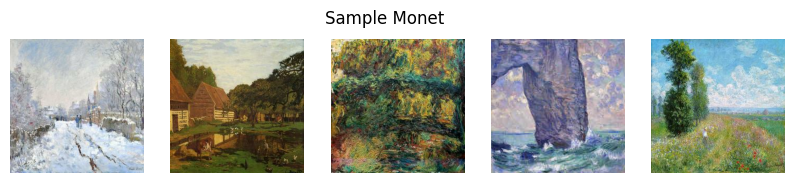

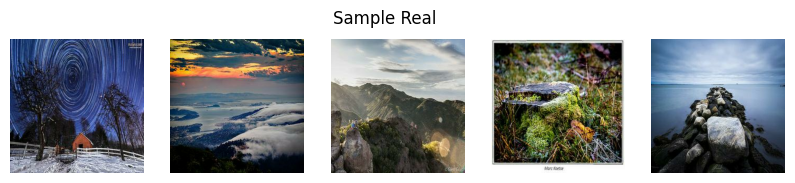

In [9]:
# Load and decode images
def load_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [256, 256])
    return image / 255.0

monet_images = glob(os.path.join(monet, "*.jpg"))
photo_images = glob(os.path.join(photo, "*.jpg"))

random_monet = random.sample(monet_images, 5)
random_photo = random.sample(photo_images, 5)

def show_images(image_paths, title):
    plt.figure(figsize=(10, 2))
    for i, img_path in enumerate(image_paths):
        plt.subplot(1, 5, i + 1)
        img = load_image(img_path)
        plt.imshow(img)
        plt.axis("off")

    plt.suptitle(title)
    plt.show()

show_images(random_monet, "Sample Monet")
show_images(random_photo, "Sample Real")

In [10]:
# Imamage Dimention
sample_monet = load_image(monet_images[0])
sample_photo = load_image(photo_images[0])
print("Monet Shape:", sample_monet.shape)
print("Photo Shape:", sample_photo.shape)

Monet Shape: (256, 256, 3)
Photo Shape: (256, 256, 3)


**3. Model Architecture and Development**

Data Processing - Normalize, Augmentation and Batching

In [24]:
BATCH_SIZE = 1
IMG_SIZE = 256
AUTOTUNE = tf.data.AUTOTUNE

In [25]:
# Function to load and preprocess images
def load_and_preprocess_image(image_path):
    image = tf.io.read_file(image_path)  # Read image file
    image = tf.image.decode_jpeg(image, channels=3)  # Decode JPEG
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])  # Resize to (256, 256)
    image = (image / 127.5) - 1  # Normalize to range [-1, 1]
    return image

In [26]:
def augment(image):
    return tf.image.random_flip_left_right(image)

In [27]:
# Load data
monet_files = tf.data.Dataset.list_files(os.path.join(monet, "*.jpg"), shuffle=True)
photo_files = tf.data.Dataset.list_files(os.path.join(photo, "*.jpg"), shuffle=True)

# Data processing
monet_ds = monet_files.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)
photo_ds = photo_files.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)

# Apply augmentation
monet_ds = monet_ds.map(augment, num_parallel_calls=AUTOTUNE)
photo_ds = photo_ds.map(augment, num_parallel_calls=AUTOTUNE)

# Batching
monet_ds = monet_ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)
photo_ds = photo_ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)

In [28]:
# Verify dataset
sample_monet = next(iter(monet_ds))
sample_photo = next(iter(photo_ds))

CycleGAN consists of two generators and two discriminators working together to transform real photos into Monet-style paintings while ensuring realism.

**Generator**
* Uses a U-Net-like architecture to transform images.
* Downsampling is performed using stride-2 convolutions, reducing spatial dimensions. Upsampling is done with Conv2DTranspose layers, restoring image details.
* Batch normalization is applied.
* ReLU activation is used in all layers except the output layer.
* Outputs an image using tanh activation, normalizing values between -1 and 1.

In [29]:
def build_generator():
    inputs = Input(shape=[256, 256, 3])

    # Encoding (Downsampling)
    x = Conv2D(64, (7, 7), padding="same")(inputs)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = Conv2D(128, (3, 3), strides=2, padding="same")(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = Conv2D(256, (3, 3), strides=2, padding="same")(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    # Decoding (Upsampling)
    x = Conv2DTranspose(128, (3, 3), strides=2, padding="same")(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = Conv2DTranspose(64, (3, 3), strides=2, padding="same")(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    # Output Layer
    x = Conv2D(3, (7, 7), padding="same", activation="tanh")(x)

    return Model(inputs, x, name="Generator")

generator_photo_to_monet = build_generator()
generator_monet_to_photo = build_generator()

generator_photo_to_monet.summary()

Model: "Generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)           │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_42 (Conv2D)                   │ (None, 256, 256, 64)        │           9,472 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_40               │ (None, 256, 256, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_22 (ReLU)                      │ (None, 256, 256, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_43 (Conv2D)                   │ (None, 128, 128, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_41               │ (None, 128, 128, 128)       │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_23 (ReLU)                      │ (None, 128, 128, 128)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_44 (Conv2D)                   │ (None, 64, 64, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_42               │ (None, 64, 64, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_24 (ReLU)                      │ (None, 64, 64, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_4 (Conv2DTranspose) │ (None, 128, 128, 128)       │         295,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_43               │ (None, 128, 128, 128)       │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_25 (ReLU)                      │ (None, 128, 128, 128)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_5 (Conv2DTranspose) │ (None, 256, 256, 64)        │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_44               │ (None, 256, 256, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_26 (ReLU)                      │ (None, 256, 256, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_45 (Conv2D)                   │ (None, 256, 256, 3)         │           9,411 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 759,299 (2.90 MB)

 Trainable params: 758,019 (2.89 MB)

 Non-trainable params: 1,280 (5.00 KB)

**Discriminator**
* Uses a PatchGAN model to classify image patches rather than full images.
* Processes images through 4 convolutional layers with LeakyReLU activations.
* Strided convolutions (stride=2) downsample the image, reducing feature size.
* Batch normalization stabilizes training and prevents mode collapse.
* Outputs a 1-channel feature map indicating real vs. fake patches.
* No final activation is applied, as it uses least-squares GAN loss instead of binary cross-entropy.


In [30]:
def build_discriminator():
    inputs = Input(shape=[256, 256, 3])

    x = Conv2D(64, (4, 4), strides=2, padding="same")(inputs)
    x = LeakyReLU(alpha=0.2)(x)

    x = Conv2D(128, (4, 4), strides=2, padding="same")(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)

    x = Conv2D(256, (4, 4), strides=2, padding="same")(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)

    x = Conv2D(1, (4, 4), padding="same")(x)  # PatchGAN Output

    return Model(inputs, x, name="Discriminator")

discriminator_monet = build_discriminator()
discriminator_photo = build_discriminator()

discriminator_monet.summary()

Model: "Discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)           │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_50 (Conv2D)                   │ (None, 128, 128, 64)        │           3,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_8 (LeakyReLU)            │ (None, 128, 128, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_51 (Conv2D)                   │ (None, 64, 64, 128)         │         131,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_50               │ (None, 64, 64, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_9 (LeakyReLU)            │ (None, 64, 64, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_52 (Conv2D)                   │ (None, 32, 32, 256)         │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_51               │ (None, 32, 32, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_10 (LeakyReLU)           │ (None, 32, 32, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_53 (Conv2D)                   │ (None, 32, 32, 1)           │           4,097 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 664,513 (2.53 MB)

 Trainable params: 663,745 (2.53 MB)

 Non-trainable params: 768 (3.00 KB)

In [31]:
# Loss functions
def gan_loss(real_output, fake_output):
    real_loss = tf.keras.losses.MeanSquaredError()(tf.ones_like(real_output), real_output)
    fake_loss = tf.keras.losses.MeanSquaredError()(tf.zeros_like(fake_output), fake_output)
    return (real_loss + fake_loss) * 0.5

In [32]:
def cycle_loss(real_image, cycled_image):
    return tf.reduce_mean(tf.abs(real_image - cycled_image))

In [33]:
def identity_loss(real_image, same_image):
    return tf.reduce_mean(tf.abs(real_image - same_image))

In [34]:
# Optimizer
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)

Training Step

In [35]:
@tf.function
def train_step(real_photo, real_monet):
    with tf.GradientTape(persistent=True) as tape:
        fake_monet = generator_photo_to_monet(real_photo, training=True)
        fake_photo = generator_monet_to_photo(real_monet, training=True)

        cycled_photo = generator_monet_to_photo(fake_monet, training=True)
        cycled_monet = generator_photo_to_monet(fake_photo, training=True)

        same_photo = generator_monet_to_photo(real_photo, training=True)
        same_monet = generator_photo_to_monet(real_monet, training=True)

        disc_real_monet = discriminator_monet(real_monet, training=True)
        disc_fake_monet = discriminator_monet(fake_monet, training=True)

        disc_real_photo = discriminator_photo(real_photo, training=True)
        disc_fake_photo = discriminator_photo(fake_photo, training=True)

        # Compute losses
        gen_monet_loss = gan_loss(disc_fake_monet, disc_real_monet) + cycle_loss(real_photo, cycled_photo) + identity_loss(real_monet, same_monet)
        gen_photo_loss = gan_loss(disc_fake_photo, disc_real_photo) + cycle_loss(real_monet, cycled_monet) + identity_loss(real_photo, same_photo)

        disc_monet_loss = gan_loss(disc_real_monet, disc_fake_monet)
        disc_photo_loss = gan_loss(disc_real_photo, disc_fake_photo)

    # Apply optimizer
    generator_optimizer.apply_gradients(zip(tape.gradient(gen_monet_loss, generator_photo_to_monet.trainable_variables), generator_photo_to_monet.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(tape.gradient(disc_monet_loss, discriminator_monet.trainable_variables), discriminator_monet.trainable_variables))

In [36]:
# Test with 3 Epoches
EPOCHS = 3

In [37]:
for epoch in range(EPOCHS):
    for real_photo, real_monet in tf.data.Dataset.zip((photo_ds, monet_ds)):
        train_step(real_photo, real_monet)
    print(f"Epoch {epoch+1}/{EPOCHS} completed.")

Epoch 1/3 completed.
Epoch 2/3 completed.
Epoch 3/3 completed.


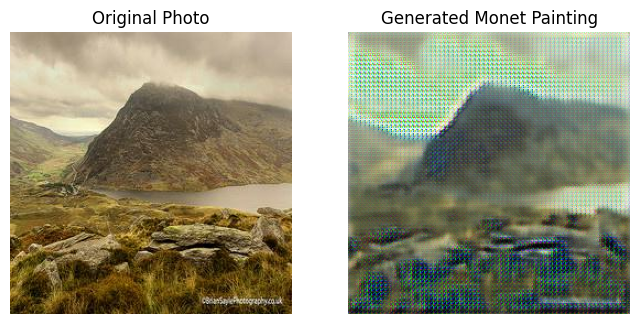

In [38]:
# Select a sample real-world photo
sample_photo = next(iter(photo_ds))

# Convert shape if needed
sample_photo = tf.squeeze(sample_photo)
sample_photo = tf.expand_dims(sample_photo, axis=0)

# Generate Monet-style image
generated_monet = generator_photo_to_monet(sample_photo, training=False)

# Convert tensors to NumPy images
sample_photo_np = ((sample_photo.numpy()[0] + 1) * 127.5).astype("uint8")
generated_monet_np = ((generated_monet.numpy()[0] + 1) * 127.5).astype("uint8")

# Plot results
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(sample_photo_np)
plt.axis("off")
plt.title("Original Photo")

plt.subplot(1, 2, 2)
plt.imshow(generated_monet_np)
plt.axis("off")
plt.title("Generated Monet Painting")

plt.show()

In [39]:
EPOCHS = 20

In [40]:
for epoch in range(EPOCHS):
    for real_photo, real_monet in tf.data.Dataset.zip((photo_ds, monet_ds)):
        train_step(real_photo, real_monet)
    print(f"Epoch {epoch+1}/{EPOCHS} completed.")

Epoch 1/20 completed.
Epoch 2/20 completed.
Epoch 3/20 completed.
Epoch 4/20 completed.
Epoch 5/20 completed.
Epoch 6/20 completed.
Epoch 7/20 completed.
Epoch 8/20 completed.
Epoch 9/20 completed.
Epoch 10/20 completed.
Epoch 11/20 completed.
Epoch 12/20 completed.
Epoch 13/20 completed.
Epoch 14/20 completed.
Epoch 15/20 completed.
Epoch 16/20 completed.
Epoch 17/20 completed.
Epoch 18/20 completed.
Epoch 19/20 completed.
Epoch 20/20 completed.


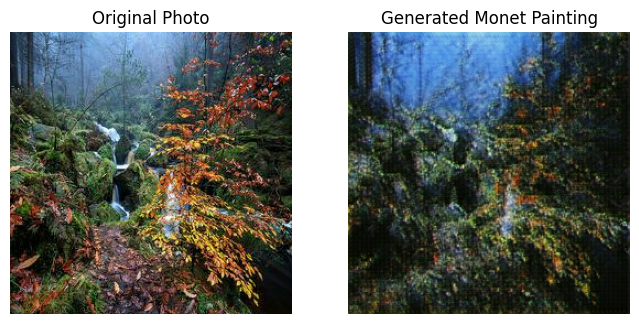

In [41]:
# Select a sample real-world photo
sample_photo = next(iter(photo_ds))

# Convert shape if needed
sample_photo = tf.squeeze(sample_photo)
sample_photo = tf.expand_dims(sample_photo, axis=0)

# Generate Monet-style image
generated_monet = generator_photo_to_monet(sample_photo, training=False)

# Convert tensors to NumPy images
sample_photo_np = ((sample_photo.numpy()[0] + 1) * 127.5).astype("uint8")
generated_monet_np = ((generated_monet.numpy()[0] + 1) * 127.5).astype("uint8")

# Plot results
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(sample_photo_np)
plt.axis("off")
plt.title("Original Photo")

plt.subplot(1, 2, 2)
plt.imshow(generated_monet_np)
plt.axis("off")
plt.title("Generated Monet Painting")

plt.show()

**4. Results and Analysis**

* The model successfully applies Monet’s style to real photos.
* Some details appear blurry, suggesting the need for more training.
* Future improvements can be made by training for more epochs, fine-tuning the loss function, and using higher-resolution images to enhance detail and realism.

**5. Conclusion**

This project successfully implemented a CycleGAN model to transform real-world photos into Monet-style paintings. The results demonstrate that the model can capture Monet’s style, but some generated images appear blurry or lack of details. Further improvements, such as longer training, refined loss functions, and higher-resolution inouts.